In [1]:
%load_ext line_profiler

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
from scipy.integrate import solve_ivp
from numpy import cos, sin
from numba import jit

plt.rcParams["figure.figsize"] = (20,20)



In [2]:
numba_options = {
    "nopython": True,
    "nogil": True,
}

last_N_c = 1e-32

F = 0
g = -9.8
m_c = 1.0
m_p = 0.1
M = m_c + m_p
l = 0.5
m_l = m_p * l
mu_c = 0.1
mu_p = 0.01

# @jit(**numba_options)
# def sgn(x: float) -> bool:
#     return (x > 0) - (x < 0)

from numpy import sign as sgn

# @jit(**numba_options)
def N_c(g, M, m_L, theta, thetadot, thetaddot):
    return g * M - m_l * (thetaddot * sin(theta) + thetadot ** 2 * cos(theta))

# @jit(**numba_options)
def derivatives(t, y, last_N_c):
    q = y[0]
    a = y[1]
    x = y[2]
    b = y[3]
    
    alpha = mu_c * sgn(last_N_c * b)
    
    adot = (
        (
            g * sin(q) + 
            cos(q) * (
                (
                    -F - m_l * a**2 * (sin(q) + alpha * cos(q))
                )
                / M
                + g * alpha
            )
            - mu_p * a / m_l
        )
        /
        (
            l * (
                4/3
                - (m_p * cos(q) / M) * (
                    cos(q) - alpha
                )
            )
        )
    )
    
    new_N_c = N_c(g, M, m_l, q, a, adot)
    
    bdot = ((F + m_l * (a**2 * sin(q) - adot * cos(q))) - last_N_c * alpha ) / M
    
    derivs = [
        a,
        adot,
        b,
        bdot,
    ]
    
    return (derivs, new_N_c)

def derivatives_wrapper(t, y):
    global last_N_c
    
    derivs, new_N_c = derivatives(t, y, last_N_c)
    
    should_redo = sgn(last_N_c) != sgn(new_N_c)
    should_redo = False
    # We have changed sign of N_c, so we should recalculate adot based on the new sign
    
    last_N_c = new_N_c
    
    if should_redo:
        print("Recalculating due to change of sign in N_c")
        return derivatives_wrapper(t, y)
    
    return derivs


In [3]:


t = np.linspace(0, 20, 1000)

initial_conditions = [
    np.pi/2, 0, 0, 0
]


sol = solve_ivp(fun=derivatives_wrapper, t_span=[t[0], t[-1]], y0=initial_conditions, method="LSODA")
print(sol)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 3521
     njev: 362
      nlu: 362
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 1.34450581e-07, 2.68901162e-07, ...,
       1.99923554e+01, 1.99953804e+01, 2.00000000e+01])
 t_events: None
        y: array([[ 1.57079633e+00,  1.57079633e+00,  1.57079633e+00, ...,
         1.02476474e-01,  1.01522708e-01,  1.00067467e-01],
       [ 0.00000000e+00, -1.97642346e-06, -3.95284684e-06, ...,
        -3.15394442e-01, -3.15197931e-01, -3.14809405e-01],
       [ 0.00000000e+00, -1.65075502e-14, -1.65075502e-14, ...,
         2.53980832e+02,  2.54034519e+02,  2.54116487e+02],
       [ 0.00000000e+00,  1.22777826e-07, -3.62146395e-16, ...,
         1.77491375e+01,  1.77457902e+01,  1.77409763e+01]])
 y_events: None


In [4]:
sol.y

array([[ 1.57079633e+00,  1.57079633e+00,  1.57079633e+00, ...,
         1.02476474e-01,  1.01522708e-01,  1.00067467e-01],
       [ 0.00000000e+00, -1.97642346e-06, -3.95284684e-06, ...,
        -3.15394442e-01, -3.15197931e-01, -3.14809405e-01],
       [ 0.00000000e+00, -1.65075502e-14, -1.65075502e-14, ...,
         2.53980832e+02,  2.54034519e+02,  2.54116487e+02],
       [ 0.00000000e+00,  1.22777826e-07, -3.62146395e-16, ...,
         1.77491375e+01,  1.77457902e+01,  1.77409763e+01]])

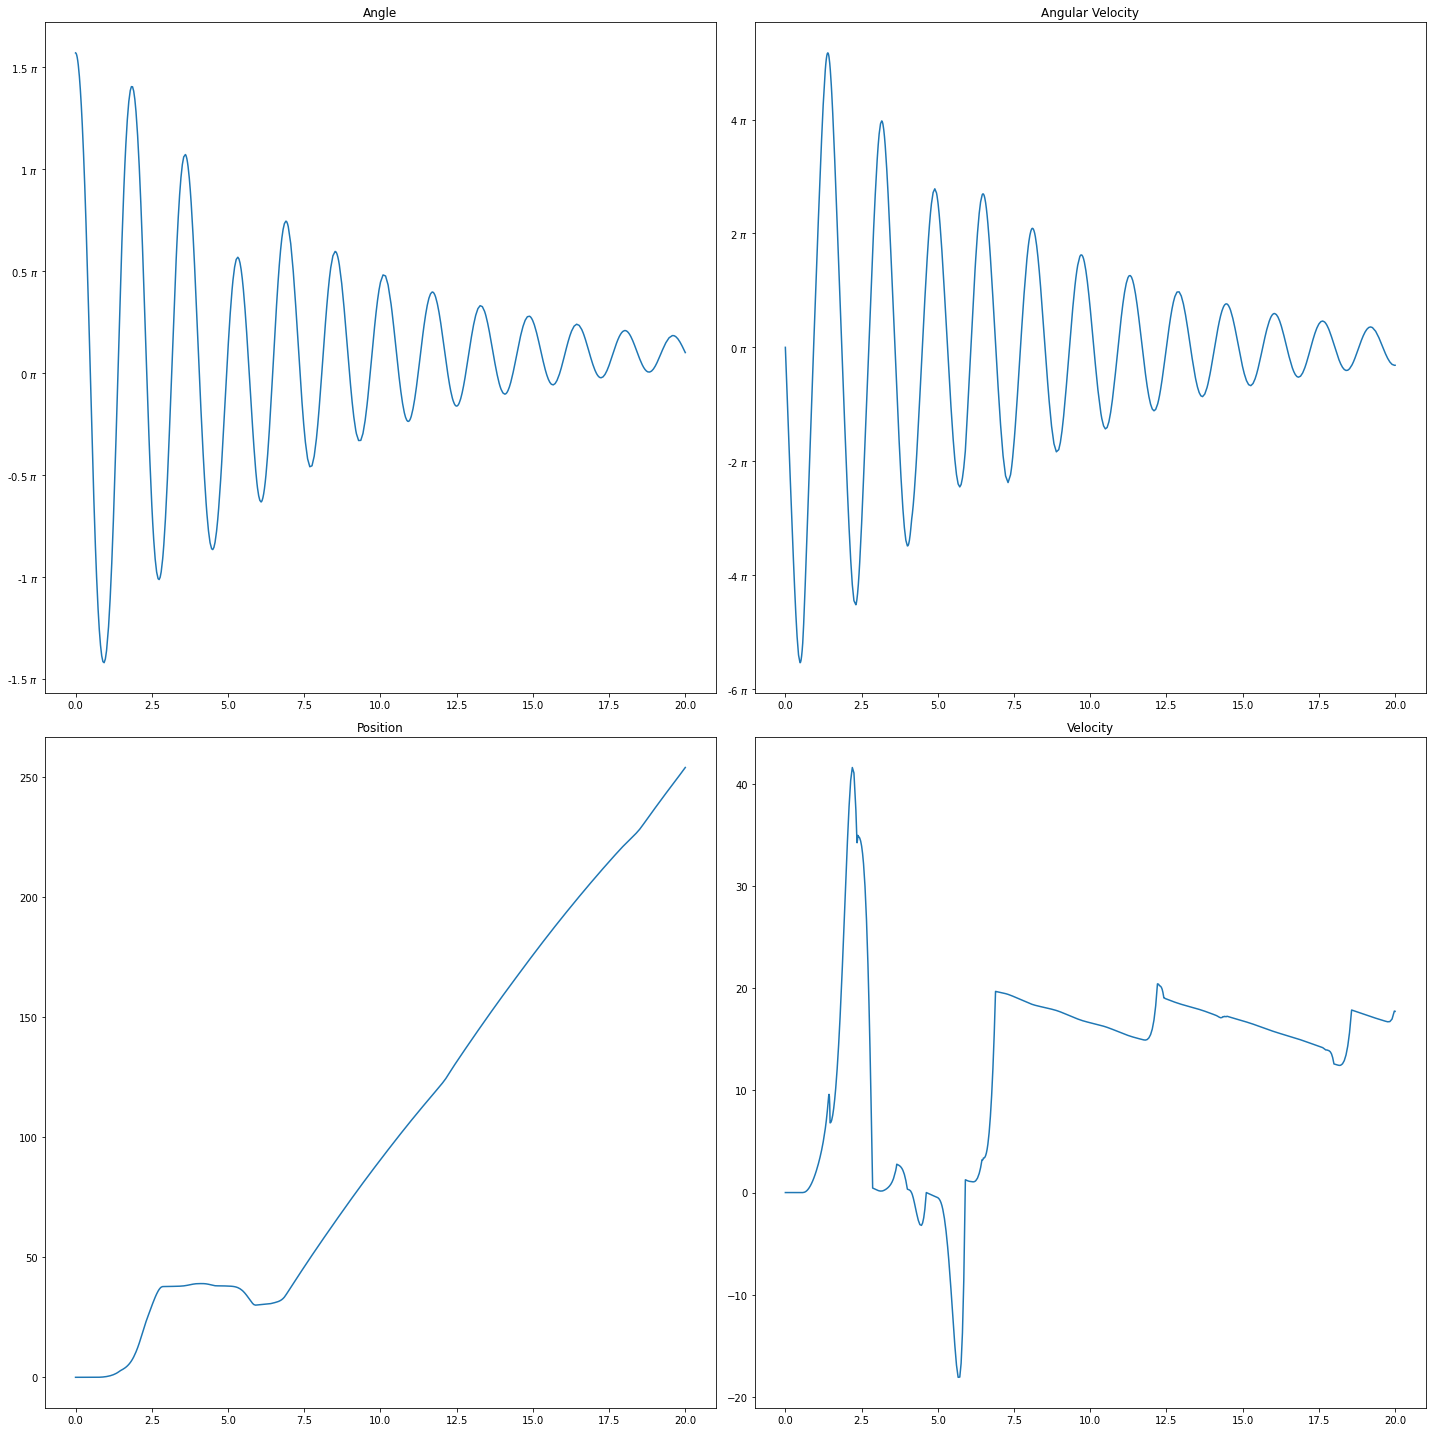

In [5]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.plot(sol.t, sol.y[0])
ax1.yaxis.set_major_formatter(FormatStrFormatter('%g $\pi$'))
ax1.title.set_text("Angle")

ax2.plot(sol.t, sol.y[1])
ax2.yaxis.set_major_formatter(FormatStrFormatter('%g $\pi$'))
ax2.title.set_text("Angular Velocity")

ax3.plot(sol.t, sol.y[2])
ax3.title.set_text("Position")

ax4.plot(sol.t, sol.y[3])
ax4.title.set_text("Velocity")

plt.tight_layout()

In [6]:
# %lprun -f derivatives_wrapper solve_ivp(fun=derivatives_wrapper, t_span=[t[0], t[-1]], y0=initial_conditions, t_eval=t, method="LSODA")